# Variational Message Passing for Estimation of a Gaussian Mixture Model

In this demo we showcase a slightly more advanced use of VMP. We wish to perform full Bayesian inference in a two-component Gaussian mixture model:

\begin{align*}
    z_i &\sim \mathcal{B}er(\pi)\\
    y_i &\sim
    \begin{cases}
        \mathcal{N}(m_1, w_1^{-1}) &\text{if } z_i = 1\\
        \mathcal{N}(m_2, w_2^{-1}) &\text{otherwise}.
    \end{cases}
\end{align*}

All model parametes $\{\pi, m_1, m_2, w_1, w_2\}$ are endowed with priors:

\begin{align*}
    \pi &\sim \mathcal{B}eta(1,1)\\
    m_1, m_2 &\sim \mathcal{N}(0, 100)\\
    w_1, w_2 &\sim Gamma(0.01, 0.01)
\end{align*}

## Generate toy dataset

In [1]:
import Distributions: Normal, pdf
using Random

Random.seed!(238)
n = 50
y_data = Float64[]
pi_data = 0.3
d1 = Normal(-2., 0.75)
d2 = Normal(1.0, 0.75)
z_data = rand(n) .< pi_data
for i = 1:n
    push!(y_data, z_data[i] ? rand(d1) : rand(d2))
end

## Model specification

The `GaussianMixture` node constructor allows for a variable number of arguments. E.g. for a three-component mixture, an `m_3` and `w_3` argument may be appended. Note that in that case, the `Bernoulli` distributed variable will need to change to a `Categorical` as well.

In [2]:
using ForneyLab

g = FactorGraph()

# Specify generative model
@RV _pi ~ Beta(1.0, 1.0)
@RV m_1 ~ GaussianMeanVariance(0.0, 100.0)
@RV w_1 ~ Gamma(0.01, 0.01)
@RV m_2 ~ GaussianMeanVariance(0.0, 100.0)
@RV w_2 ~ Gamma(0.01, 0.01)

z = Vector{Variable}(undef, n)
y = Vector{Variable}(undef, n)
for i = 1:n
    @RV z[i] ~ Bernoulli(_pi)
    @RV y[i] ~ GaussianMixture(z[i], m_1, w_1, m_2, w_2)
    
    placeholder(y[i], :y, index=i)
end

## Algorithm generation

In [3]:
# Specify recognition factorization (mean-field)
q = RecognitionFactorization(_pi, m_1, w_1, m_2, w_2, z, ids=[:PI, :M1, :W1, :M2, :W2, :Z])

# Generate the algorithm
algo = variationalAlgorithm(q)
algo_F = freeEnergyAlgorithm(q);

## Execution

In [4]:
# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F));

In [5]:
data = Dict(:y => y_data)

# Prepare recognition distributions
marginals = Dict(:_pi => vague(Beta),
                 :m_1 => ProbabilityDistribution(Univariate, GaussianMeanVariance, m=-1.0, v=1e4),
                 :w_1 => vague(Gamma),
                 :m_2 => ProbabilityDistribution(Univariate, GaussianMeanVariance, m=1.0, v=1e4),
                 :w_2 => vague(Gamma))
for i = 1:n
    marginals[:z_*i] = vague(Bernoulli)
end

# Execute algorithm
n_its = 10
F = Float64[]
for i = 1:n_its
    stepZ!(data, marginals)
    stepPI!(data, marginals)
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
        
    # Store variational free energy for visualization
    push!(F, freeEnergy(data, marginals))
end

## Results

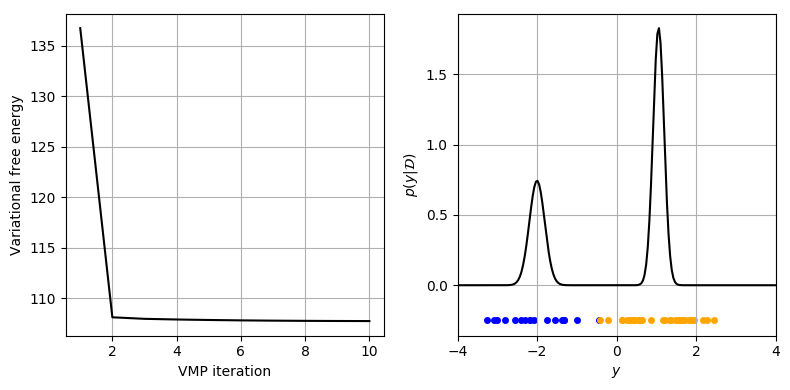

In [6]:
using PyPlot

# Plot free energy to check for convergence
figure(figsize=(8,4))
subplot(121)
plot(1:n_its, F, color="black")
grid("on")
xlabel("VMP iteration")
ylabel("Variational free energy")

# Plot data
subplot(122)
scatter(y_data[z_data], -0.25*ones(sum(z_data)), color="blue", linewidth=2, marker=".")
scatter(y_data[.!z_data], -0.25*ones(sum(.!z_data)), color="orange", linewidth=2, marker=".")

# Plot estimated distribution
x_test = range(-4, stop=4, length=200)
d1_est = Normal(mean(marginals[:m_1]), sqrt(var(marginals[:m_1])))
d2_est = Normal(mean(marginals[:m_2]), sqrt(var(marginals[:m_2])))
pi_est = mean(marginals[:_pi])
gmm_pdf = pi_est * pdf.(Ref(d1_est), x_test) + (1-pi_est) * pdf.(Ref(d2_est), x_test)
plot(x_test, gmm_pdf, color="k")
xlabel(L"y")
ylabel(L"p(y|\mathcal{D})")
xlim([-4,4])
grid()
tight_layout()